In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[9].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.71it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:21<00:00,  3.00it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 13/2000 [00:00<01:13, 26.86it/s]

Epoch 10/2000, Loss: 0.5755
Test Accuracy at Epoch 10: 64.21%
Test F1-score at Epoch 10: 0.6617
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       194
non_infringement       0.62      0.72      0.66       186

        accuracy                           0.64       380
       macro avg       0.65      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380

New best model saved with F1-score 0.6617 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.68      0.57      0.62       194
non_infringement       0.62      0.72      0.66       186

        accuracy                           0.64       380
       macro avg       0.65      0.64      0.64       380
    weighted avg       0.65      0.64      0.64       380



Training Epochs:   1%|▏         | 25/2000 [00:00<01:00, 32.79it/s]

Epoch 20/2000, Loss: 0.4145
Test Accuracy at Epoch 20: 67.89%
Test F1-score at Epoch 20: 0.7123
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.55      0.64       194
non_infringement       0.63      0.81      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.70      0.68      0.67       380

New best model saved with F1-score 0.7123 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.75      0.55      0.64       194
non_infringement       0.63      0.81      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.70      0.68      0.67       380



Training Epochs:   2%|▏         | 33/2000 [00:01<01:01, 31.83it/s]

Epoch 30/2000, Loss: 0.3544
Test Accuracy at Epoch 30: 68.42%
Test F1-score at Epoch 30: 0.7115
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.75      0.58      0.65       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.68      0.68       380



Training Epochs:   2%|▏         | 46/2000 [00:01<00:59, 32.87it/s]

Epoch 40/2000, Loss: 0.3346
Test Accuracy at Epoch 40: 68.16%
Test F1-score at Epoch 40: 0.7098
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.74      0.57      0.65       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   3%|▎         | 54/2000 [00:01<01:03, 30.57it/s]

Epoch 50/2000, Loss: 0.3142
Test Accuracy at Epoch 50: 70.00%
Test F1-score at Epoch 50: 0.7273
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

New best model saved with F1-score 0.7273 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.77      0.59      0.67       194
non_infringement       0.66      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   3%|▎         | 62/2000 [00:01<00:58, 33.07it/s]

Epoch 60/2000, Loss: 0.2960
Test Accuracy at Epoch 60: 68.68%
Test F1-score at Epoch 60: 0.7119
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.79      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.68       380
    weighted avg       0.70      0.69      0.68       380



Training Epochs:   4%|▎         | 73/2000 [00:02<01:05, 29.39it/s]

Epoch 70/2000, Loss: 0.2715
Test Accuracy at Epoch 70: 69.47%
Test F1-score at Epoch 70: 0.7198
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.76      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:   4%|▍         | 84/2000 [00:02<01:03, 30.27it/s]

Epoch 80/2000, Loss: 0.2433
Test Accuracy at Epoch 80: 72.11%
Test F1-score at Epoch 80: 0.7323
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

New best model saved with F1-score 0.7323 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   5%|▍         | 96/2000 [00:03<01:00, 31.26it/s]

Epoch 90/2000, Loss: 0.2117
Test Accuracy at Epoch 90: 69.21%
Test F1-score at Epoch 90: 0.7181
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.75      0.59      0.66       194
non_infringement       0.65      0.80      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:   5%|▌         | 104/2000 [00:03<01:04, 29.35it/s]

Epoch 100/2000, Loss: 0.1893
Test Accuracy at Epoch 100: 70.26%
Test F1-score at Epoch 100: 0.7316
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:   6%|▌         | 113/2000 [00:03<01:04, 29.40it/s]

Epoch 110/2000, Loss: 0.1644
Test Accuracy at Epoch 110: 70.53%
Test F1-score at Epoch 110: 0.7333
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380

New best model saved with F1-score 0.7333 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   6%|▌         | 122/2000 [00:04<00:59, 31.72it/s]

Epoch 120/2000, Loss: 0.1552
Test Accuracy at Epoch 120: 72.37%
Test F1-score at Epoch 120: 0.7382
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

New best model saved with F1-score 0.7382 at epoch 120
Best Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   7%|▋         | 135/2000 [00:04<00:52, 35.67it/s]

Epoch 130/2000, Loss: 0.1436
Test Accuracy at Epoch 130: 70.53%
Test F1-score at Epoch 130: 0.7333
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   7%|▋         | 143/2000 [00:04<01:07, 27.68it/s]

Epoch 140/2000, Loss: 0.1359
Test Accuracy at Epoch 140: 70.53%
Test F1-score at Epoch 140: 0.7333
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:   8%|▊         | 156/2000 [00:05<00:57, 32.00it/s]

Epoch 150/2000, Loss: 0.1331
Test Accuracy at Epoch 150: 73.16%
Test F1-score at Epoch 150: 0.7475
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

New best model saved with F1-score 0.7475 at epoch 150
Best Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   8%|▊         | 165/2000 [00:05<00:57, 32.09it/s]

Epoch 160/2000, Loss: 0.1314
Test Accuracy at Epoch 160: 71.32%
Test F1-score at Epoch 160: 0.7423
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.80      0.59      0.68       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:   9%|▊         | 173/2000 [00:05<00:59, 30.94it/s]

Epoch 170/2000, Loss: 0.1287
Test Accuracy at Epoch 170: 73.16%
Test F1-score at Epoch 170: 0.7475
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.78      0.65      0.71       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   9%|▉         | 186/2000 [00:06<00:49, 36.31it/s]

Epoch 180/2000, Loss: 0.1268
Test Accuracy at Epoch 180: 71.05%
Test F1-score at Epoch 180: 0.7393
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  10%|▉         | 195/2000 [00:06<00:50, 35.74it/s]

Epoch 190/2000, Loss: 0.1250
Test Accuracy at Epoch 190: 73.68%
Test F1-score at Epoch 190: 0.7537
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-score 0.7537 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.79      0.65      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  10%|█         | 204/2000 [00:06<00:51, 34.65it/s]

Epoch 200/2000, Loss: 0.1223
Test Accuracy at Epoch 200: 71.05%
Test F1-score at Epoch 200: 0.7393
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.71      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  11%|█         | 213/2000 [00:06<00:49, 36.01it/s]

Epoch 210/2000, Loss: 0.1206
Test Accuracy at Epoch 210: 73.95%
Test F1-score at Epoch 210: 0.7568
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380

New best model saved with F1-score 0.7568 at epoch 210
Best Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  11%|█▏        | 225/2000 [00:07<00:51, 34.57it/s]

Epoch 220/2000, Loss: 0.1184
Test Accuracy at Epoch 220: 70.79%
Test F1-score at Epoch 220: 0.7376
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.79      0.58      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.73      0.71      0.70       380



Training Epochs:  12%|█▏        | 233/2000 [00:07<00:59, 29.81it/s]

Epoch 230/2000, Loss: 0.1171
Test Accuracy at Epoch 230: 73.95%
Test F1-score at Epoch 230: 0.7568
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  12%|█▏        | 242/2000 [00:07<01:05, 26.94it/s]

Epoch 240/2000, Loss: 0.1147
Test Accuracy at Epoch 240: 70.79%
Test F1-score at Epoch 240: 0.7376
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.79      0.58      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.73      0.71      0.70       380



Training Epochs:  13%|█▎        | 251/2000 [00:08<01:00, 29.04it/s]

Epoch 250/2000, Loss: 0.1124
Test Accuracy at Epoch 250: 73.95%
Test F1-score at Epoch 250: 0.7568
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.80      0.65      0.72       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  13%|█▎        | 264/2000 [00:08<00:55, 31.37it/s]

Epoch 260/2000, Loss: 0.1097
Test Accuracy at Epoch 260: 70.26%
Test F1-score at Epoch 260: 0.7316
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.67       194
non_infringement       0.66      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  14%|█▍        | 277/2000 [00:08<00:45, 37.76it/s]

Epoch 270/2000, Loss: 0.1084
Test Accuracy at Epoch 270: 72.11%
Test F1-score at Epoch 270: 0.7440
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.69       194
non_infringement       0.68      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  14%|█▍        | 286/2000 [00:09<00:47, 36.10it/s]

Epoch 280/2000, Loss: 0.1074
Test Accuracy at Epoch 280: 71.84%
Test F1-score at Epoch 280: 0.7422
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  15%|█▍        | 295/2000 [00:09<00:48, 35.28it/s]

Epoch 290/2000, Loss: 0.1067
Test Accuracy at Epoch 290: 71.32%
Test F1-score at Epoch 290: 0.7386
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.79      0.60      0.68       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  15%|█▌        | 305/2000 [00:09<00:44, 38.39it/s]

Epoch 300/2000, Loss: 0.1078
Test Accuracy at Epoch 300: 73.42%
Test F1-score at Epoch 300: 0.7531
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       194
non_infringement       0.69      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  16%|█▌        | 318/2000 [00:09<00:43, 38.59it/s]

Epoch 310/2000, Loss: 0.1072
Test Accuracy at Epoch 310: 69.21%
Test F1-score at Epoch 310: 0.7247
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.77      0.56      0.65       194
non_infringement       0.64      0.83      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  16%|█▋        | 326/2000 [00:10<00:47, 35.06it/s]

Epoch 320/2000, Loss: 0.1059
Test Accuracy at Epoch 320: 73.42%
Test F1-score at Epoch 320: 0.7531
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       194
non_infringement       0.69      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  17%|█▋        | 335/2000 [00:10<00:45, 36.26it/s]

Epoch 330/2000, Loss: 0.1058
Test Accuracy at Epoch 330: 69.21%
Test F1-score at Epoch 330: 0.7247
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.77      0.56      0.65       194
non_infringement       0.64      0.83      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.69      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  17%|█▋        | 344/2000 [00:10<00:44, 37.19it/s]

Epoch 340/2000, Loss: 0.1047
Test Accuracy at Epoch 340: 73.42%
Test F1-score at Epoch 340: 0.7531
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.80      0.64      0.71       194
non_infringement       0.69      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  18%|█▊        | 355/2000 [00:10<00:42, 38.67it/s]

Epoch 350/2000, Loss: 0.1030
Test Accuracy at Epoch 350: 70.79%
Test F1-score at Epoch 350: 0.7351
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  18%|█▊        | 366/2000 [00:11<00:37, 43.27it/s]

Epoch 360/2000, Loss: 0.1025
Test Accuracy at Epoch 360: 70.79%
Test F1-score at Epoch 360: 0.7351
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.78      0.59      0.67       194
non_infringement       0.66      0.83      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  19%|█▉        | 375/2000 [00:11<00:43, 37.35it/s]

Epoch 370/2000, Loss: 0.1020
Test Accuracy at Epoch 370: 71.32%
Test F1-score at Epoch 370: 0.7411
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.79      0.59      0.68       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  19%|█▉        | 384/2000 [00:11<00:49, 32.85it/s]

Epoch 380/2000, Loss: 0.1012
Test Accuracy at Epoch 380: 75.00%
Test F1-score at Epoch 380: 0.7666
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7666 at epoch 380
Best Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:  20%|█▉        | 393/2000 [00:11<00:44, 36.37it/s]

Epoch 390/2000, Loss: 0.1031
Test Accuracy at Epoch 390: 69.21%
Test F1-score at Epoch 390: 0.7273
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.78      0.55      0.65       194
non_infringement       0.64      0.84      0.73       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  20%|██        | 406/2000 [00:12<00:45, 35.41it/s]

Epoch 400/2000, Loss: 0.1017
Test Accuracy at Epoch 400: 72.89%
Test F1-score at Epoch 400: 0.7518
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  21%|██        | 414/2000 [00:12<00:48, 32.58it/s]

Epoch 410/2000, Loss: 0.1003
Test Accuracy at Epoch 410: 72.89%
Test F1-score at Epoch 410: 0.7518
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  21%|██        | 423/2000 [00:12<00:49, 31.96it/s]

Epoch 420/2000, Loss: 0.1001
Test Accuracy at Epoch 420: 72.63%
Test F1-score at Epoch 420: 0.7500
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  22%|██▏       | 432/2000 [00:13<00:45, 34.53it/s]

Epoch 430/2000, Loss: 0.0997
Test Accuracy at Epoch 430: 72.63%
Test F1-score at Epoch 430: 0.7500
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  22%|██▏       | 446/2000 [00:13<00:42, 36.31it/s]

Epoch 440/2000, Loss: 0.0995
Test Accuracy at Epoch 440: 72.89%
Test F1-score at Epoch 440: 0.7518
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  23%|██▎       | 454/2000 [00:13<00:45, 34.22it/s]

Epoch 450/2000, Loss: 0.1042
Test Accuracy at Epoch 450: 74.47%
Test F1-score at Epoch 450: 0.7617
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  23%|██▎       | 463/2000 [00:13<00:41, 37.34it/s]

Epoch 460/2000, Loss: 0.0997
Test Accuracy at Epoch 460: 74.47%
Test F1-score at Epoch 460: 0.7617
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  24%|██▍       | 476/2000 [00:14<00:40, 37.17it/s]

Epoch 470/2000, Loss: 0.1008
Test Accuracy at Epoch 470: 72.63%
Test F1-score at Epoch 470: 0.7500
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.84      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  24%|██▍       | 485/2000 [00:14<00:42, 35.96it/s]

Epoch 480/2000, Loss: 0.1002
Test Accuracy at Epoch 480: 70.53%
Test F1-score at Epoch 480: 0.7358
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.79      0.58      0.67       194
non_infringement       0.66      0.84      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  25%|██▍       | 494/2000 [00:14<00:44, 34.19it/s]

Epoch 490/2000, Loss: 0.0985
Test Accuracy at Epoch 490: 72.37%
Test F1-score at Epoch 490: 0.7470
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  25%|██▌       | 508/2000 [00:15<00:37, 39.90it/s]

Epoch 500/2000, Loss: 0.0986
Test Accuracy at Epoch 500: 72.63%
Test F1-score at Epoch 500: 0.7488
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  26%|██▌       | 513/2000 [00:15<00:42, 34.86it/s]

Epoch 510/2000, Loss: 0.0983
Test Accuracy at Epoch 510: 71.84%
Test F1-score at Epoch 510: 0.7434
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  26%|██▋       | 526/2000 [00:15<00:42, 34.32it/s]

Epoch 520/2000, Loss: 0.0980
Test Accuracy at Epoch 520: 72.63%
Test F1-score at Epoch 520: 0.7488
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  27%|██▋       | 535/2000 [00:15<00:38, 38.23it/s]

Epoch 530/2000, Loss: 0.0986
Test Accuracy at Epoch 530: 74.47%
Test F1-score at Epoch 530: 0.7617
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  27%|██▋       | 544/2000 [00:16<00:39, 36.54it/s]

Epoch 540/2000, Loss: 0.0985
Test Accuracy at Epoch 540: 72.63%
Test F1-score at Epoch 540: 0.7488
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  28%|██▊       | 554/2000 [00:16<00:40, 35.39it/s]

Epoch 550/2000, Loss: 0.0995
Test Accuracy at Epoch 550: 71.84%
Test F1-score at Epoch 550: 0.7434
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  28%|██▊       | 563/2000 [00:16<00:37, 38.24it/s]

Epoch 560/2000, Loss: 0.0984
Test Accuracy at Epoch 560: 72.63%
Test F1-score at Epoch 560: 0.7488
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  29%|██▉       | 577/2000 [00:17<00:36, 38.71it/s]

Epoch 570/2000, Loss: 0.0979
Test Accuracy at Epoch 570: 71.84%
Test F1-score at Epoch 570: 0.7434
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  29%|██▉       | 585/2000 [00:17<00:38, 36.73it/s]

Epoch 580/2000, Loss: 0.0981
Test Accuracy at Epoch 580: 74.47%
Test F1-score at Epoch 580: 0.7617
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  30%|██▉       | 595/2000 [00:17<00:33, 41.41it/s]

Epoch 590/2000, Loss: 0.0974
Test Accuracy at Epoch 590: 71.84%
Test F1-score at Epoch 590: 0.7434
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  30%|███       | 604/2000 [00:17<00:40, 34.55it/s]

Epoch 600/2000, Loss: 0.0991
Test Accuracy at Epoch 600: 70.26%
Test F1-score at Epoch 600: 0.7329
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  31%|███       | 613/2000 [00:18<00:41, 33.50it/s]

Epoch 610/2000, Loss: 0.0971
Test Accuracy at Epoch 610: 71.84%
Test F1-score at Epoch 610: 0.7434
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  31%|███       | 623/2000 [00:18<00:35, 38.76it/s]

Epoch 620/2000, Loss: 0.0969
Test Accuracy at Epoch 620: 72.37%
Test F1-score at Epoch 620: 0.7470
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  32%|███▏      | 637/2000 [00:18<00:33, 40.10it/s]

Epoch 630/2000, Loss: 0.0970
Test Accuracy at Epoch 630: 71.84%
Test F1-score at Epoch 630: 0.7434
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  32%|███▏      | 642/2000 [00:18<00:33, 40.49it/s]

Epoch 640/2000, Loss: 0.0975
Test Accuracy at Epoch 640: 74.47%
Test F1-score at Epoch 640: 0.7617
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.70      0.83      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  33%|███▎      | 658/2000 [00:19<00:31, 42.46it/s]

Epoch 650/2000, Loss: 0.1049
Test Accuracy at Epoch 650: 70.26%
Test F1-score at Epoch 650: 0.7329
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  33%|███▎      | 668/2000 [00:19<00:33, 39.83it/s]

Epoch 660/2000, Loss: 0.0989
Test Accuracy at Epoch 660: 71.84%
Test F1-score at Epoch 660: 0.7434
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  34%|███▎      | 673/2000 [00:19<00:33, 40.13it/s]

Epoch 670/2000, Loss: 0.0974
Test Accuracy at Epoch 670: 72.37%
Test F1-score at Epoch 670: 0.7470
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  34%|███▍      | 688/2000 [00:19<00:31, 41.14it/s]

Epoch 680/2000, Loss: 0.0969
Test Accuracy at Epoch 680: 71.84%
Test F1-score at Epoch 680: 0.7434
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  35%|███▍      | 693/2000 [00:20<00:35, 36.65it/s]

Epoch 690/2000, Loss: 0.0965
Test Accuracy at Epoch 690: 71.84%
Test F1-score at Epoch 690: 0.7434
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  35%|███▌      | 703/2000 [00:20<00:32, 39.60it/s]

Epoch 700/2000, Loss: 0.0964
Test Accuracy at Epoch 700: 72.37%
Test F1-score at Epoch 700: 0.7470
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  36%|███▌      | 717/2000 [00:20<00:32, 39.79it/s]

Epoch 710/2000, Loss: 0.0963
Test Accuracy at Epoch 710: 72.63%
Test F1-score at Epoch 710: 0.7488
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  36%|███▌      | 722/2000 [00:20<00:35, 35.82it/s]

Epoch 720/2000, Loss: 0.0962
Test Accuracy at Epoch 720: 72.37%
Test F1-score at Epoch 720: 0.7470
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  37%|███▋      | 732/2000 [00:21<00:32, 39.58it/s]

Epoch 730/2000, Loss: 0.0962
Test Accuracy at Epoch 730: 72.63%
Test F1-score at Epoch 730: 0.7488
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  37%|███▋      | 746/2000 [00:21<00:31, 39.54it/s]

Epoch 740/2000, Loss: 0.0961
Test Accuracy at Epoch 740: 72.63%
Test F1-score at Epoch 740: 0.7488
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.80      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.72       380
    weighted avg       0.74      0.73      0.72       380



Training Epochs:  38%|███▊      | 755/2000 [00:21<00:34, 35.75it/s]

Epoch 750/2000, Loss: 0.0961
Test Accuracy at Epoch 750: 72.37%
Test F1-score at Epoch 750: 0.7458
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  38%|███▊      | 763/2000 [00:22<00:42, 29.28it/s]

Epoch 760/2000, Loss: 0.1029
Test Accuracy at Epoch 760: 73.16%
Test F1-score at Epoch 760: 0.7450
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.78      0.66      0.72       194
non_infringement       0.70      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  39%|███▉      | 776/2000 [00:22<00:37, 32.84it/s]

Epoch 770/2000, Loss: 0.1041
Test Accuracy at Epoch 770: 70.26%
Test F1-score at Epoch 770: 0.7329
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  39%|███▉      | 785/2000 [00:22<00:33, 36.03it/s]

Epoch 780/2000, Loss: 0.0967
Test Accuracy at Epoch 780: 70.26%
Test F1-score at Epoch 780: 0.7329
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  40%|███▉      | 794/2000 [00:23<00:35, 33.99it/s]

Epoch 790/2000, Loss: 0.0974
Test Accuracy at Epoch 790: 72.37%
Test F1-score at Epoch 790: 0.7458
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  40%|████      | 804/2000 [00:23<00:31, 38.37it/s]

Epoch 800/2000, Loss: 0.0973
Test Accuracy at Epoch 800: 73.68%
Test F1-score at Epoch 800: 0.7525
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  41%|████      | 818/2000 [00:23<00:29, 40.72it/s]

Epoch 810/2000, Loss: 0.0958
Test Accuracy at Epoch 810: 72.37%
Test F1-score at Epoch 810: 0.7458
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  41%|████      | 823/2000 [00:23<00:32, 36.18it/s]

Epoch 820/2000, Loss: 0.0961
Test Accuracy at Epoch 820: 71.58%
Test F1-score at Epoch 820: 0.7404
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  42%|████▏     | 833/2000 [00:23<00:29, 39.05it/s]

Epoch 830/2000, Loss: 0.0958
Test Accuracy at Epoch 830: 72.37%
Test F1-score at Epoch 830: 0.7458
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  42%|████▏     | 848/2000 [00:24<00:28, 40.21it/s]

Epoch 840/2000, Loss: 0.0957
Test Accuracy at Epoch 840: 72.11%
Test F1-score at Epoch 840: 0.7440
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.69       194
non_infringement       0.68      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  43%|████▎     | 853/2000 [00:24<00:32, 35.65it/s]

Epoch 850/2000, Loss: 0.0957
Test Accuracy at Epoch 850: 72.37%
Test F1-score at Epoch 850: 0.7458
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  43%|████▎     | 863/2000 [00:24<00:28, 40.21it/s]

Epoch 860/2000, Loss: 0.0956
Test Accuracy at Epoch 860: 72.11%
Test F1-score at Epoch 860: 0.7440
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.69       194
non_infringement       0.68      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  44%|████▍     | 878/2000 [00:25<00:26, 42.20it/s]

Epoch 870/2000, Loss: 0.0956
Test Accuracy at Epoch 870: 71.58%
Test F1-score at Epoch 870: 0.7404
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  44%|████▍     | 883/2000 [00:25<00:28, 38.82it/s]

Epoch 880/2000, Loss: 0.1022
Test Accuracy at Epoch 880: 70.00%
Test F1-score at Epoch 880: 0.7299
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  45%|████▍     | 898/2000 [00:25<00:25, 43.03it/s]

Epoch 890/2000, Loss: 0.1025
Test Accuracy at Epoch 890: 73.95%
Test F1-score at Epoch 890: 0.7543
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  45%|████▌     | 908/2000 [00:25<00:27, 40.09it/s]

Epoch 900/2000, Loss: 0.0959
Test Accuracy at Epoch 900: 72.37%
Test F1-score at Epoch 900: 0.7458
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.83      0.75       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.74      0.72      0.72       380



Training Epochs:  46%|████▌     | 913/2000 [00:26<00:26, 41.22it/s]

Epoch 910/2000, Loss: 0.0971
Test Accuracy at Epoch 910: 70.00%
Test F1-score at Epoch 910: 0.7299
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  46%|████▋     | 929/2000 [00:26<00:24, 43.11it/s]

Epoch 920/2000, Loss: 0.0958
Test Accuracy at Epoch 920: 72.11%
Test F1-score at Epoch 920: 0.7427
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  47%|████▋     | 934/2000 [00:26<00:27, 38.94it/s]

Epoch 930/2000, Loss: 0.0954
Test Accuracy at Epoch 930: 72.11%
Test F1-score at Epoch 930: 0.7427
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  47%|████▋     | 946/2000 [00:26<00:24, 43.69it/s]

Epoch 940/2000, Loss: 0.0954
Test Accuracy at Epoch 940: 71.58%
Test F1-score at Epoch 940: 0.7404
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  48%|████▊     | 956/2000 [00:27<00:25, 41.01it/s]

Epoch 950/2000, Loss: 0.0953
Test Accuracy at Epoch 950: 72.11%
Test F1-score at Epoch 950: 0.7427
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  48%|████▊     | 966/2000 [00:27<00:26, 38.61it/s]

Epoch 960/2000, Loss: 0.0953
Test Accuracy at Epoch 960: 72.11%
Test F1-score at Epoch 960: 0.7427
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  49%|████▉     | 977/2000 [00:27<00:24, 41.19it/s]

Epoch 970/2000, Loss: 0.0953
Test Accuracy at Epoch 970: 72.11%
Test F1-score at Epoch 970: 0.7427
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.79      0.62      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  49%|████▉     | 988/2000 [00:27<00:25, 40.46it/s]

Epoch 980/2000, Loss: 0.0979
Test Accuracy at Epoch 980: 73.95%
Test F1-score at Epoch 980: 0.7543
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  50%|████▉     | 993/2000 [00:27<00:23, 42.00it/s]

Epoch 990/2000, Loss: 0.0956
Test Accuracy at Epoch 990: 70.00%
Test F1-score at Epoch 990: 0.7299
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  50%|█████     | 1009/2000 [00:28<00:22, 44.29it/s]

Epoch 1000/2000, Loss: 0.0953
Test Accuracy at Epoch 1000: 73.95%
Test F1-score at Epoch 1000: 0.7543
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  51%|█████     | 1014/2000 [00:28<00:25, 38.15it/s]

Epoch 1010/2000, Loss: 0.0954
Test Accuracy at Epoch 1010: 71.58%
Test F1-score at Epoch 1010: 0.7404
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.79      0.61      0.69       194
non_infringement       0.67      0.83      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  51%|█████▏    | 1026/2000 [00:28<00:22, 43.54it/s]

Epoch 1020/2000, Loss: 0.0953
Test Accuracy at Epoch 1020: 72.11%
Test F1-score at Epoch 1020: 0.7415
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  52%|█████▏    | 1037/2000 [00:29<00:22, 43.25it/s]

Epoch 1030/2000, Loss: 0.0951
Test Accuracy at Epoch 1030: 71.32%
Test F1-score at Epoch 1030: 0.7373
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.68       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  52%|█████▏    | 1047/2000 [00:29<00:22, 42.02it/s]

Epoch 1040/2000, Loss: 0.0952
Test Accuracy at Epoch 1040: 71.32%
Test F1-score at Epoch 1040: 0.7373
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.68       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.73      0.71      0.71       380



Training Epochs:  53%|█████▎    | 1058/2000 [00:29<00:20, 44.96it/s]

Epoch 1050/2000, Loss: 0.0951
Test Accuracy at Epoch 1050: 72.37%
Test F1-score at Epoch 1050: 0.7445
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.79      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  53%|█████▎    | 1063/2000 [00:29<00:20, 45.37it/s]

Epoch 1060/2000, Loss: 0.0964
Test Accuracy at Epoch 1060: 73.95%
Test F1-score at Epoch 1060: 0.7543
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  54%|█████▍    | 1078/2000 [00:29<00:21, 43.89it/s]

Epoch 1070/2000, Loss: 0.0955
Test Accuracy at Epoch 1070: 72.11%
Test F1-score at Epoch 1070: 0.7415
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  54%|█████▍    | 1083/2000 [00:30<00:24, 37.92it/s]

Epoch 1080/2000, Loss: 0.0949
Test Accuracy at Epoch 1080: 71.58%
Test F1-score at Epoch 1080: 0.7391
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  55%|█████▍    | 1093/2000 [00:30<00:23, 39.37it/s]

Epoch 1090/2000, Loss: 0.0963
Test Accuracy at Epoch 1090: 70.00%
Test F1-score at Epoch 1090: 0.7299
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.78      0.58      0.66       194
non_infringement       0.65      0.83      0.73       186

        accuracy                           0.70       380
       macro avg       0.72      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  55%|█████▌    | 1107/2000 [00:30<00:22, 39.27it/s]

Epoch 1100/2000, Loss: 0.0949
Test Accuracy at Epoch 1100: 72.11%
Test F1-score at Epoch 1100: 0.7415
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  56%|█████▌    | 1117/2000 [00:31<00:23, 37.33it/s]

Epoch 1110/2000, Loss: 0.0949
Test Accuracy at Epoch 1110: 71.58%
Test F1-score at Epoch 1110: 0.7391
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  56%|█████▌    | 1122/2000 [00:31<00:22, 38.56it/s]

Epoch 1120/2000, Loss: 0.0950
Test Accuracy at Epoch 1120: 73.95%
Test F1-score at Epoch 1120: 0.7543
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.82      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  57%|█████▋    | 1134/2000 [00:31<00:24, 35.92it/s]

Epoch 1130/2000, Loss: 0.0953
Test Accuracy at Epoch 1130: 71.58%
Test F1-score at Epoch 1130: 0.7391
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  57%|█████▋    | 1148/2000 [00:31<00:21, 39.30it/s]

Epoch 1140/2000, Loss: 0.0950
Test Accuracy at Epoch 1140: 72.11%
Test F1-score at Epoch 1140: 0.7415
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  58%|█████▊    | 1153/2000 [00:32<00:21, 40.23it/s]

Epoch 1150/2000, Loss: 0.0948
Test Accuracy at Epoch 1150: 71.58%
Test F1-score at Epoch 1150: 0.7391
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  58%|█████▊    | 1168/2000 [00:32<00:19, 41.68it/s]

Epoch 1160/2000, Loss: 0.0949
Test Accuracy at Epoch 1160: 71.58%
Test F1-score at Epoch 1160: 0.7391
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  59%|█████▊    | 1173/2000 [00:32<00:23, 34.63it/s]

Epoch 1170/2000, Loss: 0.0948
Test Accuracy at Epoch 1170: 71.58%
Test F1-score at Epoch 1170: 0.7391
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  59%|█████▉    | 1184/2000 [00:32<00:20, 40.50it/s]

Epoch 1180/2000, Loss: 0.0960
Test Accuracy at Epoch 1180: 70.00%
Test F1-score at Epoch 1180: 0.7286
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  60%|█████▉    | 1194/2000 [00:33<00:20, 39.61it/s]

Epoch 1190/2000, Loss: 0.0949
Test Accuracy at Epoch 1190: 71.58%
Test F1-score at Epoch 1190: 0.7391
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  60%|██████    | 1200/2000 [00:33<00:19, 41.20it/s]

Epoch 1200/2000, Loss: 0.0975
Test Accuracy at Epoch 1200: 73.68%
Test F1-score at Epoch 1200: 0.7512
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  61%|██████    | 1214/2000 [00:33<00:22, 34.57it/s]

Epoch 1210/2000, Loss: 0.0954
Test Accuracy at Epoch 1210: 71.58%
Test F1-score at Epoch 1210: 0.7391
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  61%|██████    | 1223/2000 [00:33<00:20, 37.36it/s]

Epoch 1220/2000, Loss: 0.0947
Test Accuracy at Epoch 1220: 71.58%
Test F1-score at Epoch 1220: 0.7391
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  62%|██████▏   | 1234/2000 [00:34<00:20, 37.66it/s]

Epoch 1230/2000, Loss: 0.0955
Test Accuracy at Epoch 1230: 73.68%
Test F1-score at Epoch 1230: 0.7512
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  62%|██████▏   | 1246/2000 [00:34<00:16, 44.69it/s]

Epoch 1240/2000, Loss: 0.0951
Test Accuracy at Epoch 1240: 71.84%
Test F1-score at Epoch 1240: 0.7384
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  63%|██████▎   | 1257/2000 [00:34<00:16, 44.15it/s]

Epoch 1250/2000, Loss: 0.0947
Test Accuracy at Epoch 1250: 72.11%
Test F1-score at Epoch 1250: 0.7415
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1260/2000, Loss: 0.0972


Training Epochs:  63%|██████▎   | 1267/2000 [00:34<00:17, 42.39it/s]

Test Accuracy at Epoch 1260: 73.68%
Test F1-score at Epoch 1260: 0.7512
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  64%|██████▍   | 1278/2000 [00:35<00:15, 47.08it/s]

Epoch 1270/2000, Loss: 0.0945
Test Accuracy at Epoch 1270: 71.58%
Test F1-score at Epoch 1270: 0.7391
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380

Epoch 1280/2000, Loss: 0.0966
Test Accuracy at Epoch 1280: 70.00%
Test F1-score at Epoch 1280: 0.7286


Training Epochs:  64%|██████▍   | 1288/2000 [00:35<00:16, 43.50it/s]

Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  65%|██████▍   | 1299/2000 [00:35<00:14, 48.36it/s]

Epoch 1290/2000, Loss: 0.0950
Test Accuracy at Epoch 1290: 73.68%
Test F1-score at Epoch 1290: 0.7512
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1300/2000, Loss: 0.0951
Test Accuracy at Epoch 1300: 71.84%
Test F1-score at Epoch 1300: 0.7384


Training Epochs:  65%|██████▌   | 1304/2000 [00:35<00:16, 41.61it/s]

Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  66%|██████▌   | 1316/2000 [00:35<00:14, 46.90it/s]

Epoch 1310/2000, Loss: 0.0944
Test Accuracy at Epoch 1310: 71.32%
Test F1-score at Epoch 1310: 0.7361
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  66%|██████▋   | 1327/2000 [00:36<00:15, 44.75it/s]

Epoch 1320/2000, Loss: 0.0959
Test Accuracy at Epoch 1320: 70.00%
Test F1-score at Epoch 1320: 0.7286
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  67%|██████▋   | 1338/2000 [00:36<00:15, 43.73it/s]

Epoch 1330/2000, Loss: 0.0945
Test Accuracy at Epoch 1330: 71.32%
Test F1-score at Epoch 1330: 0.7348
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.77      0.62      0.69       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  67%|██████▋   | 1349/2000 [00:36<00:13, 47.72it/s]

Epoch 1340/2000, Loss: 0.0970
Test Accuracy at Epoch 1340: 73.68%
Test F1-score at Epoch 1340: 0.7512
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1350/2000, Loss: 0.0947


Training Epochs:  68%|██████▊   | 1354/2000 [00:36<00:13, 47.15it/s]

Test Accuracy at Epoch 1350: 71.58%
Test F1-score at Epoch 1350: 0.7391
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  68%|██████▊   | 1364/2000 [00:37<00:14, 43.04it/s]

Epoch 1360/2000, Loss: 0.0950
Test Accuracy at Epoch 1360: 71.58%
Test F1-score at Epoch 1360: 0.7391
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  69%|██████▊   | 1374/2000 [00:37<00:16, 38.09it/s]

Epoch 1370/2000, Loss: 0.0943
Test Accuracy at Epoch 1370: 71.84%
Test F1-score at Epoch 1370: 0.7384
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  69%|██████▉   | 1386/2000 [00:37<00:13, 45.22it/s]

Epoch 1380/2000, Loss: 0.0955
Test Accuracy at Epoch 1380: 73.68%
Test F1-score at Epoch 1380: 0.7512
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  70%|██████▉   | 1397/2000 [00:37<00:14, 42.59it/s]

Epoch 1390/2000, Loss: 0.0946
Test Accuracy at Epoch 1390: 71.84%
Test F1-score at Epoch 1390: 0.7384
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  70%|███████   | 1407/2000 [00:38<00:14, 41.43it/s]

Epoch 1400/2000, Loss: 0.0962
Test Accuracy at Epoch 1400: 70.00%
Test F1-score at Epoch 1400: 0.7286
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  71%|███████   | 1420/2000 [00:38<00:12, 47.62it/s]

Epoch 1410/2000, Loss: 0.0942
Test Accuracy at Epoch 1410: 71.84%
Test F1-score at Epoch 1410: 0.7384
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1420/2000, Loss: 0.0958
Test Accuracy at Epoch 1420: 73.68%
Test F1-score at Epoch 1420: 0.7512
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  72%|███████▏  | 1436/2000 [00:38<00:11, 48.26it/s]

Epoch 1430/2000, Loss: 0.0942
Test Accuracy at Epoch 1430: 71.05%
Test F1-score at Epoch 1430: 0.7330
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1440/2000, Loss: 0.0950
Test Accuracy at Epoch 1440: 71.58%
Test F1-score at Epoch 1440: 0.7391
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.78      0.61      0.69       194
non_infringement       0.67      0.82      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.71       380
    weighted avg       0.73      0.72      0.71       380



Training Epochs:  73%|███████▎  | 1458/2000 [00:39<00:11, 48.68it/s]

Epoch 1450/2000, Loss: 0.0949
Test Accuracy at Epoch 1450: 71.05%
Test F1-score at Epoch 1450: 0.7330
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1460/2000, Loss: 0.0950


Training Epochs:  73%|███████▎  | 1463/2000 [00:39<00:14, 37.83it/s]

Test Accuracy at Epoch 1460: 73.68%
Test F1-score at Epoch 1460: 0.7512
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  74%|███████▎  | 1474/2000 [00:39<00:12, 42.47it/s]

Epoch 1470/2000, Loss: 0.0946
Test Accuracy at Epoch 1470: 71.84%
Test F1-score at Epoch 1470: 0.7384
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  74%|███████▍  | 1484/2000 [00:39<00:12, 41.09it/s]

Epoch 1480/2000, Loss: 0.0956
Test Accuracy at Epoch 1480: 70.00%
Test F1-score at Epoch 1480: 0.7286
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  75%|███████▍  | 1495/2000 [00:40<00:13, 37.76it/s]

Epoch 1490/2000, Loss: 0.0942
Test Accuracy at Epoch 1490: 71.05%
Test F1-score at Epoch 1490: 0.7330
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  75%|███████▌  | 1506/2000 [00:40<00:11, 42.58it/s]

Epoch 1500/2000, Loss: 0.0950
Test Accuracy at Epoch 1500: 73.68%
Test F1-score at Epoch 1500: 0.7512
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  76%|███████▌  | 1517/2000 [00:40<00:11, 41.42it/s]

Epoch 1510/2000, Loss: 0.0947
Test Accuracy at Epoch 1510: 71.84%
Test F1-score at Epoch 1510: 0.7384
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  76%|███████▌  | 1522/2000 [00:40<00:11, 42.08it/s]

Epoch 1520/2000, Loss: 0.0942
Test Accuracy at Epoch 1520: 71.05%
Test F1-score at Epoch 1520: 0.7330
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  77%|███████▋  | 1538/2000 [00:41<00:10, 42.48it/s]

Epoch 1530/2000, Loss: 0.0964
Test Accuracy at Epoch 1530: 70.00%
Test F1-score at Epoch 1530: 0.7286
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.72      0.70      0.70       380



Training Epochs:  77%|███████▋  | 1548/2000 [00:41<00:11, 38.71it/s]

Epoch 1540/2000, Loss: 0.0944
Test Accuracy at Epoch 1540: 71.84%
Test F1-score at Epoch 1540: 0.7384
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  78%|███████▊  | 1553/2000 [00:41<00:10, 40.91it/s]

Epoch 1550/2000, Loss: 0.0950
Test Accuracy at Epoch 1550: 71.84%
Test F1-score at Epoch 1550: 0.7384
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  78%|███████▊  | 1569/2000 [00:41<00:09, 43.79it/s]

Epoch 1560/2000, Loss: 0.0949
Test Accuracy at Epoch 1560: 71.05%
Test F1-score at Epoch 1560: 0.7330
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  79%|███████▊  | 1574/2000 [00:42<00:10, 40.09it/s]

Epoch 1570/2000, Loss: 0.0944
Test Accuracy at Epoch 1570: 71.05%
Test F1-score at Epoch 1570: 0.7330
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  79%|███████▉  | 1586/2000 [00:42<00:09, 44.67it/s]

Epoch 1580/2000, Loss: 0.0941
Test Accuracy at Epoch 1580: 71.84%
Test F1-score at Epoch 1580: 0.7384
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  80%|███████▉  | 1596/2000 [00:42<00:09, 41.60it/s]

Epoch 1590/2000, Loss: 0.0959
Test Accuracy at Epoch 1590: 72.37%
Test F1-score at Epoch 1590: 0.7355
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  80%|████████  | 1606/2000 [00:42<00:10, 38.48it/s]

Epoch 1600/2000, Loss: 0.0940
Test Accuracy at Epoch 1600: 71.05%
Test F1-score at Epoch 1600: 0.7330
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  81%|████████  | 1618/2000 [00:43<00:08, 46.46it/s]

Epoch 1610/2000, Loss: 0.0962
Test Accuracy at Epoch 1610: 69.74%
Test F1-score at Epoch 1610: 0.7255
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380

Epoch 1620/2000, Loss: 0.0941
Test Accuracy at Epoch 1620: 71.84%
Test F1-score at Epoch 1620: 0.7384
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  82%|████████▏ | 1636/2000 [00:43<00:07, 47.84it/s]

Epoch 1630/2000, Loss: 0.0951
Test Accuracy at Epoch 1630: 73.68%
Test F1-score at Epoch 1630: 0.7512
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1640/2000, Loss: 0.0941
Test Accuracy at Epoch 1640: 71.05%
Test F1-score at Epoch 1640: 0.7330
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  83%|████████▎ | 1654/2000 [00:44<00:08, 39.08it/s]

Epoch 1650/2000, Loss: 0.0954
Test Accuracy at Epoch 1650: 71.05%
Test F1-score at Epoch 1650: 0.7330
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  83%|████████▎ | 1665/2000 [00:44<00:08, 41.83it/s]

Epoch 1660/2000, Loss: 0.0939
Test Accuracy at Epoch 1660: 71.05%
Test F1-score at Epoch 1660: 0.7330
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1670/2000, Loss: 0.0943
Test Accuracy at Epoch 1670: 71.84%
Test F1-score at Epoch 1670: 0.7384
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  84%|████████▍ | 1689/2000 [00:44<00:06, 48.80it/s]

Epoch 1680/2000, Loss: 0.0955
Test Accuracy at Epoch 1680: 73.68%
Test F1-score at Epoch 1680: 0.7512
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1690/2000, Loss: 0.0948
Test Accuracy at Epoch 1690: 71.05%
Test F1-score at Epoch 1690: 0.7330
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  85%|████████▌ | 1707/2000 [00:45<00:06, 46.67it/s]

Epoch 1700/2000, Loss: 0.0940
Test Accuracy at Epoch 1700: 71.05%
Test F1-score at Epoch 1700: 0.7330
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  86%|████████▌ | 1712/2000 [00:45<00:06, 41.72it/s]

Epoch 1710/2000, Loss: 0.0954
Test Accuracy at Epoch 1710: 72.37%
Test F1-score at Epoch 1710: 0.7355
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  86%|████████▌ | 1723/2000 [00:45<00:06, 45.46it/s]

Epoch 1720/2000, Loss: 0.0938
Test Accuracy at Epoch 1720: 71.05%
Test F1-score at Epoch 1720: 0.7330
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  87%|████████▋ | 1739/2000 [00:45<00:05, 46.93it/s]

Epoch 1730/2000, Loss: 0.0946
Test Accuracy at Epoch 1730: 71.05%
Test F1-score at Epoch 1730: 0.7330
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1740/2000, Loss: 0.0944
Test Accuracy at Epoch 1740: 71.05%
Test F1-score at Epoch 1740: 0.7330


Training Epochs:  87%|████████▋ | 1749/2000 [00:46<00:05, 44.64it/s]

Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  88%|████████▊ | 1760/2000 [00:46<00:04, 48.56it/s]

Epoch 1750/2000, Loss: 0.0938
Test Accuracy at Epoch 1750: 71.84%
Test F1-score at Epoch 1750: 0.7384
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1760/2000, Loss: 0.0956
Test Accuracy at Epoch 1760: 72.37%
Test F1-score at Epoch 1760: 0.7355
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  89%|████████▉ | 1776/2000 [00:46<00:04, 47.04it/s]

Epoch 1770/2000, Loss: 0.0938
Test Accuracy at Epoch 1770: 71.05%
Test F1-score at Epoch 1770: 0.7330
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1780/2000, Loss: 0.0962
Test Accuracy at Epoch 1780: 69.47%
Test F1-score at Epoch 1780: 0.7225


Training Epochs:  89%|████████▉ | 1786/2000 [00:46<00:04, 43.13it/s]

Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs:  90%|████████▉ | 1797/2000 [00:47<00:04, 46.07it/s]

Epoch 1790/2000, Loss: 0.0943
Test Accuracy at Epoch 1790: 73.68%
Test F1-score at Epoch 1790: 0.7512
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.79      0.66      0.72       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  90%|█████████ | 1808/2000 [00:47<00:04, 43.72it/s]

Epoch 1800/2000, Loss: 0.0942
Test Accuracy at Epoch 1800: 71.84%
Test F1-score at Epoch 1800: 0.7384
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  91%|█████████ | 1818/2000 [00:47<00:04, 42.82it/s]

Epoch 1810/2000, Loss: 0.0940
Test Accuracy at Epoch 1810: 71.05%
Test F1-score at Epoch 1810: 0.7330
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  91%|█████████▏| 1829/2000 [00:47<00:03, 47.21it/s]

Epoch 1820/2000, Loss: 0.0949
Test Accuracy at Epoch 1820: 71.05%
Test F1-score at Epoch 1820: 0.7330
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1830/2000, Loss: 0.0938


Training Epochs:  92%|█████████▏| 1834/2000 [00:48<00:03, 47.30it/s]

Test Accuracy at Epoch 1830: 71.05%
Test F1-score at Epoch 1830: 0.7330
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  92%|█████████▏| 1844/2000 [00:48<00:03, 44.32it/s]

Epoch 1840/2000, Loss: 0.0937
Test Accuracy at Epoch 1840: 71.84%
Test F1-score at Epoch 1840: 0.7384
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1850/2000, Loss: 0.0937
Test Accuracy at Epoch 1850: 71.84%
Test F1-score at Epoch 1850: 0.7384


Training Epochs:  93%|█████████▎| 1855/2000 [00:48<00:03, 40.55it/s]

Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  93%|█████████▎| 1866/2000 [00:48<00:02, 45.08it/s]

Epoch 1860/2000, Loss: 0.0985
Test Accuracy at Epoch 1860: 71.05%
Test F1-score at Epoch 1860: 0.7194
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  94%|█████████▍| 1877/2000 [00:49<00:02, 42.33it/s]

Epoch 1870/2000, Loss: 0.0979
Test Accuracy at Epoch 1870: 69.74%
Test F1-score at Epoch 1870: 0.7255
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.77      0.58      0.66       194
non_infringement       0.65      0.82      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.70      0.69       380



Training Epochs:  94%|█████████▍| 1888/2000 [00:49<00:02, 42.94it/s]

Epoch 1880/2000, Loss: 0.0976
Test Accuracy at Epoch 1880: 72.37%
Test F1-score at Epoch 1880: 0.7355
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  95%|█████████▍| 1899/2000 [00:49<00:02, 48.15it/s]

Epoch 1890/2000, Loss: 0.0942
Test Accuracy at Epoch 1890: 71.05%
Test F1-score at Epoch 1890: 0.7330
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1900/2000, Loss: 0.0937
Test Accuracy at Epoch 1900: 71.05%
Test F1-score at Epoch 1900: 0.7330
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  96%|█████████▌| 1914/2000 [00:49<00:01, 43.10it/s]

Epoch 1910/2000, Loss: 0.0937
Test Accuracy at Epoch 1910: 71.84%
Test F1-score at Epoch 1910: 0.7384
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1920/2000, Loss: 0.0937


Training Epochs:  96%|█████████▋| 1925/2000 [00:50<00:01, 41.86it/s]

Test Accuracy at Epoch 1920: 71.05%
Test F1-score at Epoch 1920: 0.7330
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  97%|█████████▋| 1937/2000 [00:50<00:01, 48.38it/s]

Epoch 1930/2000, Loss: 0.0937
Test Accuracy at Epoch 1930: 71.05%
Test F1-score at Epoch 1930: 0.7330
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1940/2000, Loss: 0.0936
Test Accuracy at Epoch 1940: 71.84%
Test F1-score at Epoch 1940: 0.7384
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  98%|█████████▊| 1959/2000 [00:50<00:00, 49.09it/s]

Epoch 1950/2000, Loss: 0.0937
Test Accuracy at Epoch 1950: 71.84%
Test F1-score at Epoch 1950: 0.7384
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  98%|█████████▊| 1965/2000 [00:51<00:00, 42.28it/s]

Epoch 1960/2000, Loss: 0.0950
Test Accuracy at Epoch 1960: 71.05%
Test F1-score at Epoch 1960: 0.7194
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1970/2000, Loss: 0.0938


Training Epochs:  99%|█████████▉| 1976/2000 [00:51<00:00, 47.40it/s]

Test Accuracy at Epoch 1970: 71.84%
Test F1-score at Epoch 1970: 0.7384
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.78      0.63      0.70       194
non_infringement       0.68      0.81      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  99%|█████████▉| 1987/2000 [00:51<00:00, 43.29it/s]

Epoch 1980/2000, Loss: 0.0936
Test Accuracy at Epoch 1980: 71.05%
Test F1-score at Epoch 1980: 0.7330
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.77      0.61      0.68       194
non_infringement       0.67      0.81      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1990/2000, Loss: 0.0957


Training Epochs: 100%|█████████▉| 1997/2000 [00:51<00:00, 40.01it/s]

Test Accuracy at Epoch 1990: 69.47%
Test F1-score at Epoch 1990: 0.7225
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.76      0.58      0.66       194
non_infringement       0.65      0.81      0.72       186

        accuracy                           0.69       380
       macro avg       0.71      0.70      0.69       380
    weighted avg       0.71      0.69      0.69       380



Training Epochs: 100%|██████████| 2000/2000 [00:51<00:00, 38.57it/s]
/tmp/ipykernel_1461526/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0936
Test Accuracy at Epoch 2000: 70.53%
Test F1-score at Epoch 2000: 0.7228
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.69       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



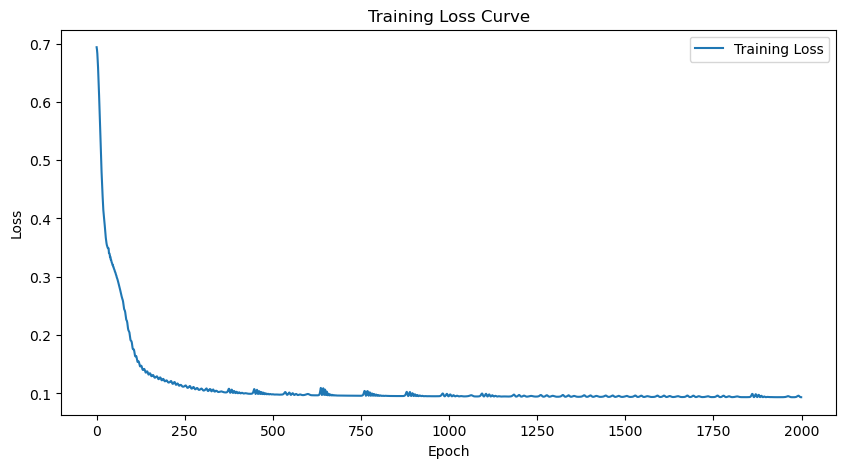

Final Model Accuracy: 75.00%
Final Model F1-score: 0.7666


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 75.00%
                  precision    recall  f1-score   support

    infringement       0.81      0.66      0.73       194
non_infringement       0.71      0.84      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



/tmp/ipykernel_1461526/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
